In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import keras

2024-05-12 11:35:14.482897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 11:35:14.482929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 11:35:14.483965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 11:35:14.489466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 11:35:15.232637: W tensorflow/compiler/tf2

In [3]:
# Create list of all targets
dataset_path = '/home/pmedur/strojnoUcenje/env/bin/TorchAudio/SpeechCommands/speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
all_targets.remove('.ipynb_checkpoints')
all_targets.remove('pozdrav')
print(all_targets)

['stop', 'up', 'learn', 'bird', 'follow', 'wow', 'on', 'marvin', 'tree', 'no', 'dog', 'happy', 'off', 'down', 'six', 'sheila', 'bed', 'seven', 'visual', 'four', 'right', 'five', 'cat', 'house', 'left', 'go', 'eight', 'forward', 'one', 'yes', 'two', 'backward', 'nine', 'three', 'zero']


In [4]:
# Settings
feature_sets_path = '/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_1_filename = 'wake_word_stop_model_1.h5'
model_2_filename = 'wake_word_stop_model_2.h5'
model_3_filename = 'wake_word_stop_model_3.h5'
model_4_filename = 'wake_word_stop_model_4.h5'
model_5_filename = 'wake_word_stop_model_5.h5'
model_q_filename = 'wake_word_stop_model_q.h5'
wake_word = 'go'

In [5]:
# Loading feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [6]:
# Assigning feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [7]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77494, 16, 16)
(9692, 16, 16)
(9670, 16, 16)


In [8]:
print(y_val)

[32. 25.  1. ... 13. 34.  1.]


In [9]:
# Converting ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [10]:
# Percentage of 'go' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.037040858439950475
0.9629591415600496


In [11]:
# CNN for TF expects (batch, height, width, channels)
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)

In [12]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [74]:
# CNN model
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [75]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(16,
                          (3,3),
                          activation="relu",
                          input_shape=sample_shape))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Conv2D(32,
                          (3,3),
                          activation="relu",
                          ))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [76]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(16,
                          (3,3),
                          activation="relu",
                          input_shape=sample_shape))
model_3.add(layers.MaxPooling2D(pool_size=(8, 8)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dropout(0.3))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [77]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(64,
                          (5,5),
                          activation="relu",
                          input_shape=sample_shape))
model_4.add(layers.MaxPooling2D(pool_size=(5, 5)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(32, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [78]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(8,
                          (4,4),
                          activation="tanh",
                          input_shape=sample_shape))
model_5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_5.add(layers.Flatten())
model_5.add(layers.Dense(1, activation='sigmoid'))

In [49]:
# Display model
model_1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 1, 1, 64)        

In [50]:
model_2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 5, 5, 32)          4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 2, 2, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 32)              

In [51]:
model_3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 1, 1, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 16)                272       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                     

In [52]:
model_4.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 12, 12, 64)        1664      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 2, 2, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 32)                8224      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9921 (38.75 KB)
Trainable params: 9921 (38.75 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [79]:
model_5.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 13, 13, 8)         136       
                                                                 
 average_pooling2d_4 (Avera  (None, 6, 6, 8)           0         
 gePooling2D)                                                    
                                                                 
 flatten_22 (Flatten)        (None, 288)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 289       
                                                                 
Total params: 425 (1.66 KB)
Trainable params: 425 (1.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
# Add training parameters to model
model_1.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_2.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_3.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_4.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_5.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

In [81]:
# Train
history_1 = model_1.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 4ms/step - loss: 0.1456 - acc: 0.9625 - val_loss: 0.1051 - val_acc: 0.9649
Epoch 2/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0988 - acc: 0.9674 - val_loss: 0.0855 - val_acc: 0.9712
Epoch 3/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0847 - acc: 0.9710 - val_loss: 0.0820 - val_acc: 0.9723
Epoch 4/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0791 - acc: 0.9730 - val_loss: 0.0740 - val_acc: 0.9750
Epoch 5/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0721 - acc: 0.9750 - val_loss: 0.0729 - val_acc: 0.9754
Epoch 6/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0671 - acc: 0.9772 - val_loss: 0.0952 - val_acc: 0.9727
Epoch 7/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0650 - acc: 0.9780 - val_loss: 0.0711 - val_acc: 0.9769
Epoch 8/30
303/303 [==============================] - 1s 4ms/step - loss: 0.

In [82]:
# Train
history_2 = model_2.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 4ms/step - loss: 0.1680 - acc: 0.9596 - val_loss: 0.1106 - val_acc: 0.9631
Epoch 2/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1100 - acc: 0.9655 - val_loss: 0.0911 - val_acc: 0.9682
Epoch 3/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0943 - acc: 0.9678 - val_loss: 0.0851 - val_acc: 0.9696
Epoch 4/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0866 - acc: 0.9700 - val_loss: 0.0852 - val_acc: 0.9708
Epoch 5/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0803 - acc: 0.9721 - val_loss: 0.0768 - val_acc: 0.9732
Epoch 6/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0760 - acc: 0.9730 - val_loss: 0.0722 - val_acc: 0.9743
Epoch 7/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0719 - acc: 0.9743 - val_loss: 0.0692 - val_acc: 0.9757
Epoch 8/30
303/303 [==============================] - 1s 3ms/step - loss: 0.

In [83]:
# Train
history_3 = model_3.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 3ms/step - loss: 0.2816 - acc: 0.9263 - val_loss: 0.1725 - val_acc: 0.9630
Epoch 2/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1827 - acc: 0.9631 - val_loss: 0.1615 - val_acc: 0.9630
Epoch 3/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1685 - acc: 0.9637 - val_loss: 0.1544 - val_acc: 0.9630
Epoch 4/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1615 - acc: 0.9638 - val_loss: 0.1500 - val_acc: 0.9630
Epoch 5/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1571 - acc: 0.9638 - val_loss: 0.1473 - val_acc: 0.9630
Epoch 6/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1536 - acc: 0.9638 - val_loss: 0.1437 - val_acc: 0.9630
Epoch 7/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1496 - acc: 0.9639 - val_loss: 0.1409 - val_acc: 0.9630
Epoch 8/30
303/303 [==============================] - 1s 3ms/step - loss: 0.

In [84]:
# Train
history_4 = model_4.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 4ms/step - loss: 0.1488 - acc: 0.9597 - val_loss: 0.1091 - val_acc: 0.9646
Epoch 2/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0931 - acc: 0.9692 - val_loss: 0.0934 - val_acc: 0.9706
Epoch 3/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0829 - acc: 0.9724 - val_loss: 0.0898 - val_acc: 0.9701
Epoch 4/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0743 - acc: 0.9747 - val_loss: 0.0766 - val_acc: 0.9748
Epoch 5/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0706 - acc: 0.9757 - val_loss: 0.0720 - val_acc: 0.9757
Epoch 6/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0694 - acc: 0.9764 - val_loss: 0.0763 - val_acc: 0.9746
Epoch 7/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0664 - acc: 0.9772 - val_loss: 0.0770 - val_acc: 0.9740
Epoch 8/30
303/303 [==============================] - 1s 3ms/step - loss: 0.

In [85]:
# Train
history_5 = model_5.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 3ms/step - loss: 0.2087 - acc: 0.9410 - val_loss: 0.1438 - val_acc: 0.9630
Epoch 2/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1322 - acc: 0.9640 - val_loss: 0.1297 - val_acc: 0.9631
Epoch 3/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1251 - acc: 0.9642 - val_loss: 0.1263 - val_acc: 0.9632
Epoch 4/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1215 - acc: 0.9644 - val_loss: 0.1222 - val_acc: 0.9634
Epoch 5/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1178 - acc: 0.9649 - val_loss: 0.1191 - val_acc: 0.9637
Epoch 6/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1145 - acc: 0.9650 - val_loss: 0.1160 - val_acc: 0.9640
Epoch 7/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1113 - acc: 0.9652 - val_loss: 0.1128 - val_acc: 0.9644
Epoch 8/30
303/303 [==============================] - 1s 2ms/step - loss: 0.

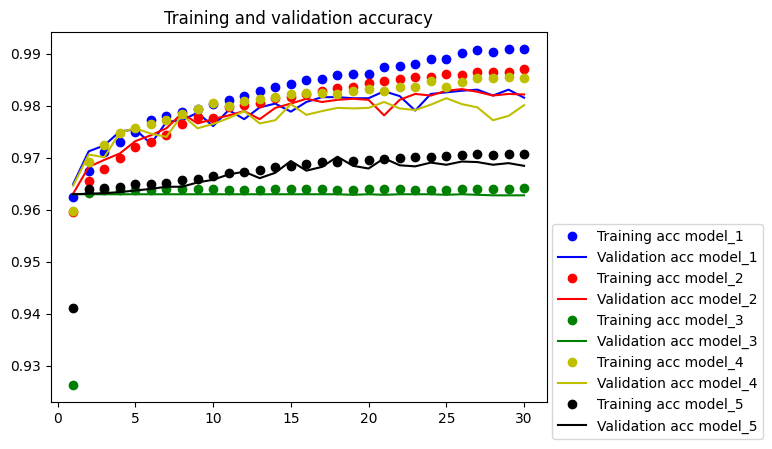

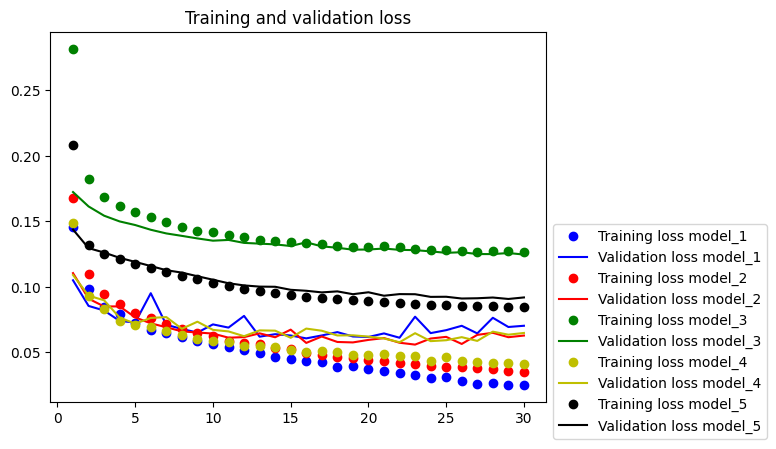

In [91]:
# Plot results
import matplotlib.pyplot as plt

acc_1 = history_1.history['acc']
val_acc_1 = history_1.history['val_acc']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

acc_2 = history_2.history['acc']
val_acc_2 = history_2.history['val_acc']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

acc_3 = history_3.history['acc']
val_acc_3 = history_3.history['val_acc']
loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

acc_4 = history_4.history['acc']
val_acc_4 = history_4.history['val_acc']
loss_4 = history_4.history['loss']
val_loss_4 = history_4.history['val_loss']

acc_5 = history_5.history['acc']
val_acc_5 = history_5.history['val_acc']
loss_5 = history_5.history['loss']
val_loss_5 = history_5.history['val_loss']

epochs = range(1, len(acc_1) + 1)

plt.plot(epochs, acc_1, 'bo', label='Training acc model_1')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc model_1')
plt.plot(epochs, acc_2, 'ro', label='Training acc model_2')
plt.plot(epochs, val_acc_2, 'r', label='Validation acc model_2')
plt.plot(epochs, acc_3, 'go', label='Training acc model_3')
plt.plot(epochs, val_acc_3, 'g', label='Validation acc model_3')
plt.plot(epochs, acc_4, 'yo', label='Training acc model_4')
plt.plot(epochs, val_acc_4, 'y', label='Validation acc model_4')
plt.plot(epochs, acc_5, 'ko', label='Training acc model_5')
plt.plot(epochs, val_acc_5, 'k', label='Validation acc model_5')
plt.title('Training and validation accuracy')
plt.legend( bbox_to_anchor=(1.45, 0.5), fontsize=10)

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss model_1')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss model_1')
plt.plot(epochs, loss_2, 'ro', label='Training loss model_2')
plt.plot(epochs, val_loss_2, 'r', label='Validation loss model_2')
plt.plot(epochs, loss_3, 'go', label='Training loss model_3')
plt.plot(epochs, val_loss_3, 'g', label='Validation loss model_3')
plt.plot(epochs, loss_4, 'yo', label='Training loss model_4')
plt.plot(epochs, val_loss_4, 'y', label='Validation loss model_4')
plt.plot(epochs, loss_5, 'ko', label='Training loss model_5')
plt.plot(epochs, val_loss_5, 'k', label='Validation loss model_5')
plt.title('Training and validation loss')
plt.legend( bbox_to_anchor=(1, 0.5), fontsize=10)

plt.show()

In [94]:
models.save_model(model_1, model_1_filename)
models.save_model(model_2, model_2_filename)
models.save_model(model_3, model_3_filename)
models.save_model(model_4, model_4_filename)
models.save_model(model_5, model_5_filename)

/tmp/ipykernel_5354/758715730.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model_1, model_1_filename)
/tmp/ipykernel_5354/758715730.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model_2, model_2_filename)
/tmp/ipykernel_5354/758715730.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model_3, model_3_filename)
/tmp/ipykernel_5354/758715730.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered 

In [21]:
# See which are 'go'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

9
34
146
147
154
172
176
184
193
196
246
248
273
304
323
333
334
338
381
393
454
464
550
559
580
639
677
688
707
729
778
779
798
806
813
814
819
839
862
874
885
994
1002
1010
1042
1071
1091
1118
1183
1200
1222
1230
1289
1297
1355
1402
1403
1482
1500
1517
1549
1610
1613
1645
1669
1702
1709
1769
1781
1794
1818
1823
1858
1871
1875
1881
1883
1886
1924
1980
1987
2007
2019
2020
2070
2098
2129
2160
2174
2192
2229
2242
2294
2314
2371
2387
2409
2430
2440
2468
2469
2615
2630
2638
2652
2691
2708
2710
2724
2733
2739
2790
2795
2822
2842
2846
2864
2868
2917
2924
2956
2959
3019
3030
3065
3074
3146
3157
3161
3193
3264
3269
3272
3285
3290
3317
3353
3359
3381
3403
3409
3459
3468
3484
3563
3570
3575
3630
3639
3698
3700
3702
3717
3744
3837
3869
3893
3922
3939
3941
3953
3964
4005
4042
4055
4087
4134
4166
4175
4186
4220
4234
4245
4261
4280
4363
4364
4405
4418
4512
4524
4547
4565
4571
4574
4591
4601
4606
4626
4636
4656
4696
4700
4754
4805
4809
4826
4827
4839
4859
4919
4942
5019
5069
5088
5095
5121
5124
5166


In [95]:
# Loading model and run it against test set
model_1 = models.load_model(model_1_filename)
for i in range(0, 100):
    print('Answer:', y_test[i], ' Prediction:', model_1.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 154ms/step
Answer: 0.0  Prediction: [[7.675902e-05]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[1.7816707e-05]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[8.777879e-05]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[1.9631097e-08]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[2.401358e-10]]
1/1 [==============================] - 0s 14ms/step
Answer: 0.0  Prediction: [[3.2179797e-09]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[0.01031086]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[0.00331593]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[1.5238603e-05]]
1/1 [==============================] - 0s 14ms/step
Answer: 0.0  Prediction: [[3.7072237e-08]]
1/1 [==============================] - 0s 13ms/step
Answer

In [96]:
# Evaluate model with test set
model_1.evaluate(x=x_test, y=y_test)
model_2.evaluate(x=x_test, y=y_test)
model_3.evaluate(x=x_test, y=y_test)
model_4.evaluate(x=x_test, y=y_test)
model_5.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 0s 1ms/step - loss: 0.0890 - acc: 0.9696


[0.08904550224542618, 0.9695966839790344]

303/303 [==============================] - 0s 1ms/step - loss: 0.0890 - acc: 0.9696


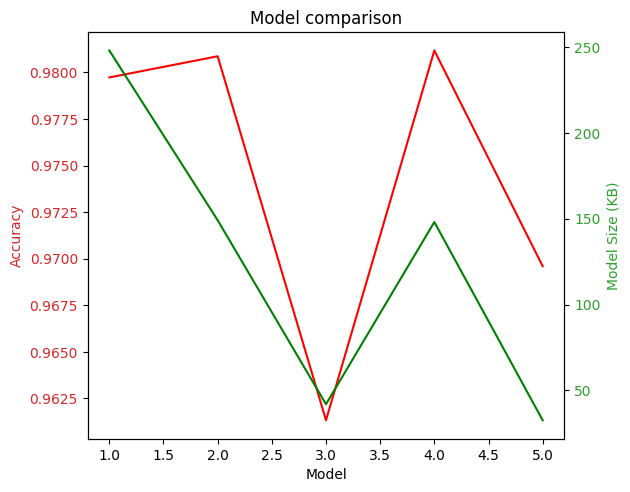

In [101]:
import matplotlib.pyplot as plt
import os

acc_values = []
acc_values.append(model_1.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_2.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_3.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_4.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_5.evaluate(x=x_test, y=y_test)[1])

model_size = []
model_size.append(os.path.getsize('wake_word_stop_model_1.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_2.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_3.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_4.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_5.h5') / 1024)

models = range(1, 6)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(models, acc_values, 'r', label='Accuracy values')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Model Size (KB)', color=color)  
ax2.plot(models, model_size, 'g', label='Model size')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  

plt.title('Model comparison')

plt.show()


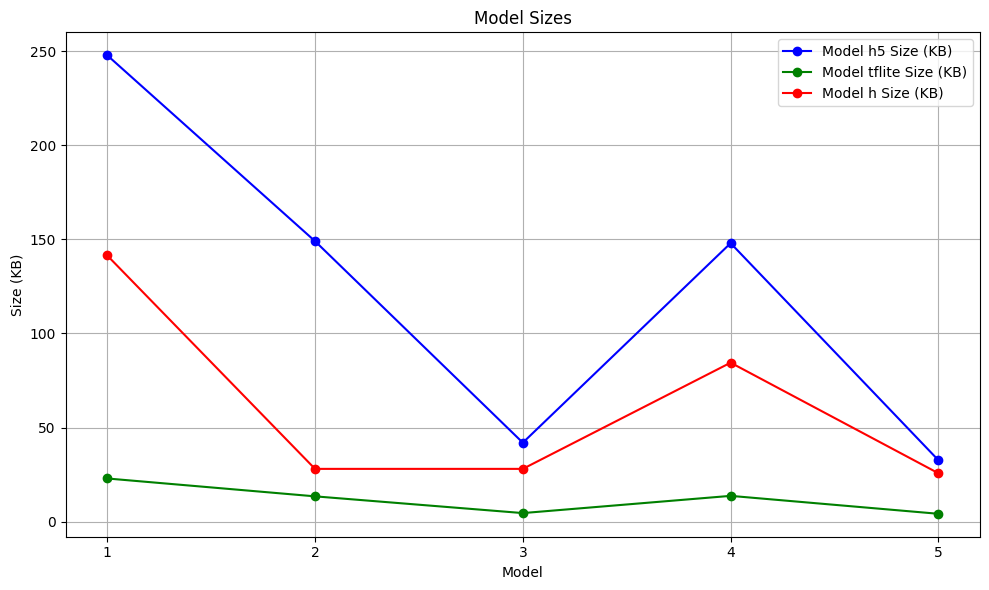

In [4]:
import os
import matplotlib.pyplot as plt

model_h5_size = []
model_h5_size.append(os.path.getsize('wake_word_stop_model_1.h5') / 1024)
model_h5_size.append(os.path.getsize('wake_word_stop_model_2.h5') / 1024)
model_h5_size.append(os.path.getsize('wake_word_stop_model_3.h5') / 1024)
model_h5_size.append(os.path.getsize('wake_word_stop_model_4.h5') / 1024)
model_h5_size.append(os.path.getsize('wake_word_stop_model_5.h5') / 1024)

model_tflite_size = []
model_tflite_size.append(os.path.getsize('wake_word_stop_lite_1.tflite') / 1024)
model_tflite_size.append(os.path.getsize('wake_word_stop_lite_2.tflite') / 1024)
model_tflite_size.append(os.path.getsize('wake_word_stop_lite_3.tflite') / 1024)
model_tflite_size.append(os.path.getsize('wake_word_stop_lite_4.tflite') / 1024)
model_tflite_size.append(os.path.getsize('wake_word_stop_lite_5.tflite') / 1024)

model_h_size = []
model_h_size.append(os.path.getsize('wake_word_stop_1_h.h') / 1024)
model_h_size.append(os.path.getsize('wake_word_stop_2_h.h') / 1024)
model_h_size.append(os.path.getsize('wake_word_stop_3_h.h') / 1024)
model_h_size.append(os.path.getsize('wake_word_stop_4_h.h') / 1024)
model_h_size.append(os.path.getsize('wake_word_stop_5_h.h') / 1024)

models = range(1, 6)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(models, model_h5_size, marker='o', linestyle='-', label='Model h5 Size (KB)', color='blue')
plt.plot(models, model_tflite_size, marker='o', linestyle='-', label='Model tflite Size (KB)', color='green')
plt.plot(models, model_h_size, marker='o', linestyle='-', label='Model h Size (KB)', color='red')

plt.xlabel('Model')
plt.ylabel('Size (KB)')
plt.title('Model Sizes')
plt.xticks(models)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [102]:
# tflite model_4 is 13.7 Kb
# .h model_4 file is 84,5

In [30]:
#Test: TF lite model
#interpreter = tf.lite.Interpreter('/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master/wake_word_stop_lite.tflite')

#interpreter.allocate_tensors()

# Get input and output tensors.
#input_details = interpreter.get_input_details()
#output_details = interpreter.get_output_details()

#input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#interpreter.set_tensor(input_details[0]['index'], input_data)

#interpreter.invoke()


#output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data)

[[0.00439723]]


In [37]:
model_tf_filename = "wake_word_stop_lite_2.tflite"
interpreter = tf.lite.Interpreter(model_path=model_tf_filename)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Initialize predictions array
predictions = np.zeros((len(x_test),), dtype=int)

predicted_labels = []
true_labels = []

# Iterate through test data
for i in range(len(x_test)):
    test_image = x_test[i]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details[0]['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details[0]["quantization"]
        test_image = test_image / input_scale + input_zero_point

    # Expand dimensions to match input shape
    test_image = np.expand_dims(test_image, axis=0).astype(input_details[0]["dtype"])

    # Set input tensor
    interpreter.set_tensor(input_details[0]["index"], test_image)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output = interpreter.get_tensor(output_details[0]["index"])[0]

    # Store prediction
    predicted_label = np.argmax(output)
    true_label = y_test[i]

    # Append to lists
    predicted_labels.append(predicted_label)
    true_labels.append(true_label)

    # Print prediction and true label
    #print("Prediction: {}, True Label: {}".format(predicted_label, true_label))

# Calculate accuracy
correct_predictions = np.array(predicted_labels) == np.array(true_labels)
accuracy = np.mean(correct_predictions) * 100

print("Accuracy: {:.2f}%".format(accuracy))


Accuracy: 96.16%


In [45]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='wake_word_stop_lite_4.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set up your input data.
input_data = x_test.shape[1:]



# Invoke the model on the input data
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get the result 
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

#e_result = np.argmax(hand)
#prob = str(round(hand[np.argmax(hand)], 2))

ValueError: Cannot set tensor: Got value of type INT64 but expected type FLOAT32 for input 0, name: serving_default_conv2d_31_input:0 

In [47]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="wake_word_stop_lite_4.tflite")
interpreter.allocate_tensors()

# Get details about the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print details about the input tensor
print("Input Tensor Details:")
print(input_details)

# Print details about the output tensor
print("Output Tensor Details:")
print(output_details)

# Optionally, print details about all tensors
all_details = interpreter.get_tensor_details()
print("All Tensor Details:")
print(all_details)


Input Tensor Details:
[{'name': 'serving_default_conv2d_31_input:0', 'index': 0, 'shape': array([ 1, 16, 16,  1], dtype=int32), 'shape_signature': array([-1, 16, 16,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Tensor Details:
[{'name': 'StatefulPartitionedCall:0', 'index': 13, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
All Tensor Details:
[{'name': 'serving_default_conv2d_31_input:0', 'index': 0, 'shape': array([ 1, 16, 16,  1], dtype=int32), 'shape_signature': array([-1, 16, 16,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, '